## Imports

In [385]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.signal import medfilt
from scipy.optimize import curve_fit

import warnings

## Data Loading

In [386]:
# --- Data Loading ---

def lpr_cor_import(filename):
    """ Import cor file as pandas dataframe."""

    try: 
        df = pd.read_csv(
            filename,
            skiprows=26,
            sep='\s+',
            header=None,
            names=["E", "i", "T"],
        ) 
        df.drop(columns=["T"], inplace=True)
        df.drop(df.head(150).index, inplace=True)
        df["E"] = df["E"]*1e3 # Convert it to mV
        
    except FileNotFoundError as e:
        print(f"Error: File was not found.")
        print(e.message)
        print(e.args)
        return None
    except Exception as e:
        print(f"Error reading the CSV file: {e}")
        return None   
    else:
        return df

In [387]:
HS1_1 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_1.cor")
HS1_2 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_2.cor")
HS1_3 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_3.cor")
HS1_4 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_4.cor")
HS1_5 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_5.cor")
HS1_6 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_6.cor")

# Keep it in the same cell to keep df reproducible, even if Vi clicks it multiple times
area = 2 #cm^2

for df in [HS1_1, HS1_2, HS1_3, HS1_4, HS1_5, HS1_6]:
    df["i"] = np.abs(df["i"]/area) # Current density


In [388]:
HS1_1 

E             i
150  -205.357  4.661220e-11
151  -205.347  4.660095e-11
152  -205.337  4.661040e-11
153  -205.327  4.662150e-11
154  -205.317  4.661900e-11
...       ...           ...
3999 -166.870  7.752900e-11
4000 -166.854  7.931000e-11
4001 -166.857  7.781400e-11
4002 -166.850  7.296700e-11
4003 -166.846  6.987300e-11

[3854 rows x 2 columns]

# Coding part!

Separate code into analyze and plotting, with all answers in a dict.
Can't believe it took me this long to really do it this way :|

## Analyze Tafel Data

In [389]:


def analyze_tafel_data(
    data: pd.DataFrame
) -> dict | None:

    INITIAL_KERNEL = 29
    FIT_KERNEL = 99
    
    # 1. Estimate Corrosion Potential (Ecorr) using a median filter
    ecorr_guess = data['E'].iloc[np.argmin(medfilt(data['i'], kernel_size=INITIAL_KERNEL))]

    # 2. Split data into anodic and cathodic regions based on Ecorr
    anodic_data = data[data['E'] > ecorr_guess]
    cathodic_data = data[data['E'] < ecorr_guess]
    if anodic_data.empty or cathodic_data.empty:
        warnings.warn("No data in anodic or cathodic regions?. Ecorr guess may be incorrect.")    
    
    # 3. Perform linear fit on E vs. i for each branch
    medfilt_anodic_i = medfilt(anodic_data['i'].iloc[30:-90], kernel_size=FIT_KERNEL)
    p_anodic = np.poly1d(np.polyfit(medfilt_anodic_i, anodic_data['E'].iloc[30:-90], 1))
    medfilt_cathodic_i = medfilt(cathodic_data['i'].iloc[30:-90], kernel_size=FIT_KERNEL)
    p_cathodic = np.poly1d(np.polyfit(medfilt_cathodic_i, cathodic_data['E'].iloc[30:-90], 1))
    
    # 4. Calculate the tangent at the extreme ends of the filtered data
    i_extreme_anodic = medfilt_anodic_i.max()
    e_extreme_anodic = p_anodic(i_extreme_anodic)
    tangent_slope_anodic = p_anodic.coeffs[0] * (i_extreme_anodic * np.log(10))

    i_extreme_cathodic = medfilt_cathodic_i.max()
    e_extreme_cathodic = p_cathodic(i_extreme_cathodic)
    tangent_slope_cathodic = p_cathodic.coeffs[0] * (i_extreme_cathodic * np.log(10))

    print(f"tangent_slope_anodic   {tangent_slope_anodic}")
    print(f"tangent_slope_cathodic {tangent_slope_cathodic}")
    print(f"p_anodic   {p_anodic}")
    print(f"p_cathodic {p_cathodic}")

          
    # 5. Calculate tangent lines    
    log_i_extreme_anodic = np.log10(i_extreme_anodic)
    log_i_tangent_anodic = np.linspace(log_i_extreme_anodic - 0.5, log_i_extreme_anodic, 100)
    e_tangent_anodic = (
        tangent_slope_anodic * (log_i_tangent_anodic - log_i_extreme_anodic)
        + e_extreme_anodic
    )

    log_i_extreme_cathodic = np.log10(i_extreme_cathodic)
    log_i_tangent_cathodic = np.linspace(log_i_extreme_cathodic - 0.5, log_i_extreme_cathodic, 100)
    e_tangent_cathodic = (
        tangent_slope_cathodic * (log_i_tangent_cathodic - log_i_extreme_cathodic)
        + e_extreme_cathodic
    )


    # --- 3. Calculations ---
    temp_kelvin = 25.0 + 273.15
    R = 8.314  # Ideal Gas Constant (J/(mol·K))
    F = 96485  # Faraday Constant (C/mol)
    n = 2 # Number of electrons transferred in your electrochemical reaction.    
    
    # Calculate the anodic charge transfer coefficient (alpha_a)
    # This value represents the fraction of the potential that assists the oxidation reaction.
    try:
        alpha_a = (2.303 * R * temp_kelvin) / (1e-3 * tangent_slope_anodic * n * F)
        alpha_c = -(2.303 * R * temp_kelvin) / (1e-3 * tangent_slope_cathodic * n * F)    
    except ZeroDivisionError as e:
        print("Slope is zero, what happened?")
        print(e)
  
    
    # 6. Package results into a dictionary
    results = {
        "ecorr_guess": ecorr_guess,
        "beta_a": tangent_slope_anodic,        
        "beta_c": tangent_slope_cathodic,
        "alpha_a": alpha_a,        
        "alpha_c": alpha_c,        
        "anodic_tangent_i": 10**log_i_tangent_anodic,
        "anodic_tangent_E": e_tangent_anodic,
        "cathodic_tangent_i": 10**log_i_tangent_cathodic,
        "cathodic_tangent_E": e_tangent_cathodic,   
    }
    return results

## Plotting code

Plot the additional stuff only if you have results.
Use the same function for everything
Again, why didn't I do this earlier :|


In [390]:
def plot_tafel(data: pd.DataFrame, results: dict):
    """
    Generates and displays a Tafel plot from the data and analysis results.

    Args:
        data (pd.DataFrame): The original experimental data.
        results (dict): The dictionary returned by analyze_tafel_data.
    """
    fig, ax = plt.subplots(figsize=(8, 4), dpi=150)

    # Plot the raw experimental data
    ax.semilogx(
        np.abs(data["i"].to_numpy()), data["E"].to_numpy(),
        marker='o', linestyle='', markersize=3, alpha=0.6, label="Experimental Data"
    )

    # Plot the analysis results if available
    if results:
        
        ax.axhline(  # Ecorr line
            y=results["ecorr_guess"],
            color='green', linestyle='--', linewidth=2,
            label=f'$E_{{corr}}$ = {results["ecorr_guess"]:.2f} mV'
        )
        
        ax.plot(     # Anodic tangent line
            results["anodic_tangent_i"], results["anodic_tangent_E"],
            color='red', linestyle='-.', linewidth=2,
            label=f'Anodic Tangent {results["beta_a"]:.2f}'
        )
        
        ax.plot(     # Cathodic tangent line
            results["cathodic_tangent_i"], results["cathodic_tangent_E"],
            color='blue', linestyle='-.', linewidth=2,
            label=f'Cathodic Tangent {results["beta_c"]:.2f}'
        )

        bx = ax.twinx()  
        ymin, ymax = ax.get_ylim()
        bx.set_ylim(ymin-results["ecorr_guess"], ymax-results["ecorr_guess"])
        bx.set_ylabel("Overpotential (mV)")
    
    # Configure plot aesthetics
    ax.set_xlabel("Current (A)")
    ax.set_ylabel("Potential (mV)")
    ax.legend()
    ax.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


## Funspace

tangent_slope_anodic   36.935982391954994
tangent_slope_cathodic -51.83557582444677
p_anodic    
2.397e+11 x - 184
p_cathodic  
-5.013e+11 x - 182
alpha_a 0.8009387773094865
alpha_c 0.5707173134514494
1.3716560907609359

tangent_slope_anodic   32.33609922748971
tangent_slope_cathodic -54.09410507385739
p_anodic    
2.421e+11 x - 182.5
p_cathodic  
-5.052e+11 x - 181.2
alpha_a 0.9148741277546404
alpha_c 0.5468888067441983
1.4617629344988385

tangent_slope_anodic   33.64593158958795
tangent_slope_cathodic -52.384158766821365
p_anodic    
2.375e+11 x - 182.9
p_cathodic  
-5.358e+11 x - 181.2
alpha_a 0.8792581800556247
alpha_c 0.5647405870813464
1.4439987671369712

tangent_slope_anodic   36.99409502392016
tangent_slope_cathodic -48.72756466526758
p_anodic    
2.566e+11 x - 184.8
p_cathodic  
-5.508e+11 x - 182.9
alpha_a 0.7996806127196425
alpha_c 0.6071196206697334
1.4068002333893759

tangent_slope_anodic   39.037818290543065
tangent_slope_cathodic -48.123338398882495
p_anodic    
2.673e+1

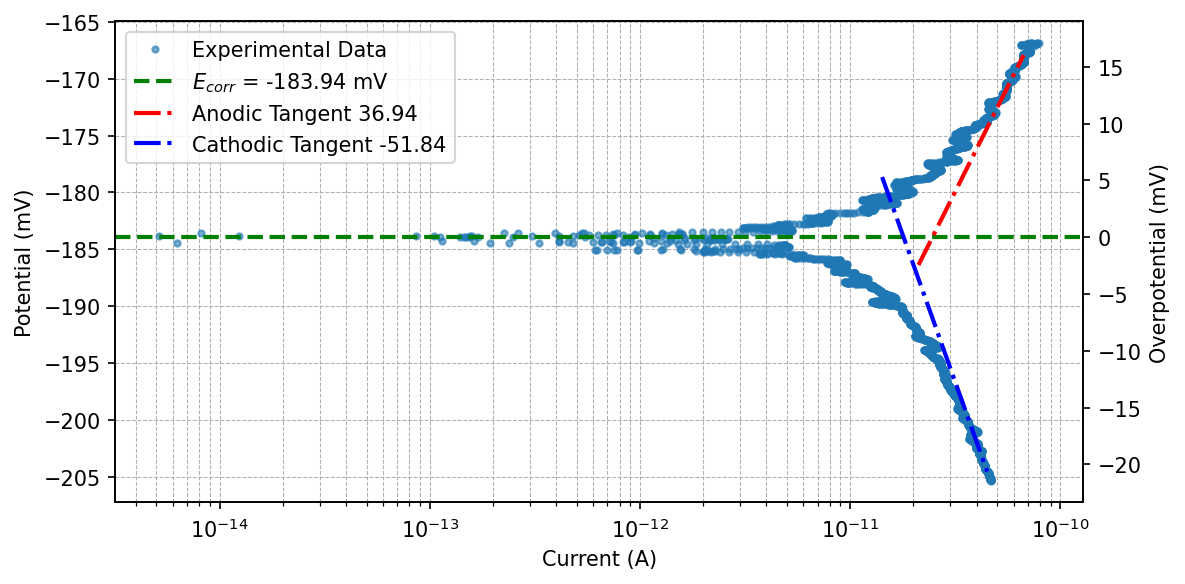

In [391]:
# =============================================================================
# --- Main Execution Block ---
# =============================================================================

# 1. Analyze the dataset
for HS1_df in [HS1_1, HS1_2, HS1_3, HS1_4, HS1_5, HS1_6]:
    analysis_results = analyze_tafel_data(HS1_df)
    print(f"alpha_a {analysis_results['alpha_a']}")
    print(f"alpha_c {analysis_results['alpha_c']}")
    print(analysis_results['alpha_a'] + analysis_results['alpha_c'])
    print()

analysis_results = analyze_tafel_data(HS1_1)

# 2. Plot the results
if analysis_results:
    plot_tafel(HS1_1, analysis_results)
else:
    print("Analysis could not be completed.")

#print(analysis_results)

# Test space

14.303656914399205 15.62901295498541
alpha_a 0.52
alpha_c 0.47
0.9902749736726397


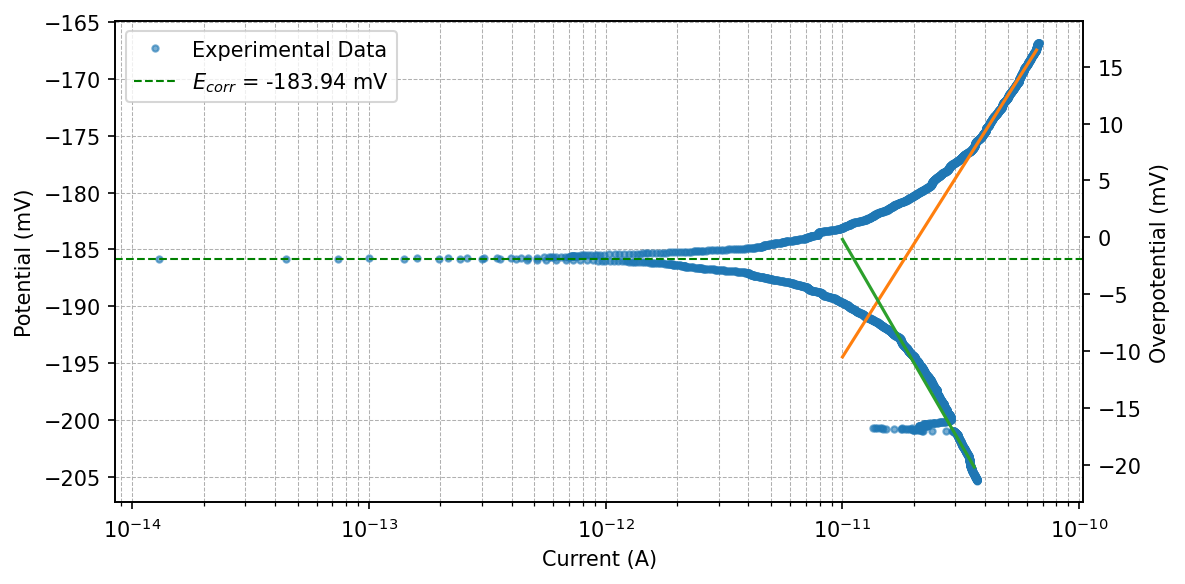

In [426]:
def plot_tafel(data: pd.DataFrame):

    
    fig, ax = plt.subplots(figsize=(8, 4), dpi=150)

    # Plot the raw experimental data
    ax.semilogx(
        np.abs(data["i"].to_numpy()), data["E"].to_numpy(),
        marker='o', linestyle='', markersize=3, alpha=0.6, label="Experimental Data"
    )

    INITIAL_KERNEL = 29
    FIT_KERNEL = 99

    # 1. Estimate Corrosion Potential (Ecorr) using a median filter
    ecorr_guess = data['E'].iloc[np.argmin(medfilt(data['i'], kernel_size=INITIAL_KERNEL))]

    ax.axhline(  # Ecorr line
        y=ecorr_guess,
        color='green', linestyle='--', linewidth=1,
        label=f'$E_{{corr}}$ = {results["ecorr_guess"]:.2f} mV'
    )
    ax.set_xlabel("Current (A)")
    ax.set_ylabel("Potential (mV)")

    bx = ax.twinx()  
    ymin, ymax = ax.get_ylim()
    bx.set_ylim(ymin-results["ecorr_guess"], ymax-results["ecorr_guess"])
    bx.set_ylabel("Overpotential (mV)")    

    # 2. Split data into anodic and cathodic regions based on Ecorr
    anodic_data = data[data['E'] > ecorr_guess + 10].copy()
    cathodic_data = data[data['E'] < ecorr_guess - 10].copy()
    #anodic_data = anodic_data
    
    anodic_data["i"] = medfilt(anodic_data['i'], kernel_size=FIT_KERNEL)
    cathodic_data["i"] = medfilt(cathodic_data['i'], kernel_size=FIT_KERNEL)
    
    if anodic_data.empty or cathodic_data.empty:
        warnings.warn("No data in anodic or cathodic regions?. Ecorr guess may be incorrect.")    

    p_anodic = np.poly1d(np.polyfit(np.log(anodic_data["i"]), anodic_data['E'], 1))
    p_cathodic = np.poly1d(np.polyfit(np.log(cathodic_data["i"]), cathodic_data['E'], 1))
    
    anodic_x = np.linspace(anodic_data["i"].max(), 10**-11, 100)
    cathodic_x = np.linspace(cathodic_data["i"].max(), 10**-11, 100)
    
    beta_a = p_anodic[1]
    beta_c = -p_cathodic[1]

    print(f"{beta_a} {beta_c}")
    
    ax.plot(anodic_x, p_anodic(np.log(anodic_x)), '-', markersize=1)
    ax.plot(cathodic_x, p_cathodic(np.log(cathodic_x)), '-', markersize=1)

    # --- 3. Calculations ---
    temp_kelvin = 25.0 + 273.15
    R = 8.314  # Ideal Gas Constant (J/(mol·K))
    F = 96485  # Faraday Constant (C/mol)
    n = 8 # Number of electrons transferred in your electrochemical reaction.    
    
    # Calculate the anodic charge transfer coefficient (alpha_a)
    # This value represents the fraction of the potential that assists the oxidation reaction.
    try:
        alpha_a = (2.303 * R * temp_kelvin) / (1e-3 * beta_a * n * F)
        alpha_c = (2.303 * R * temp_kelvin) / (1e-3 * beta_c * n * F)    
    except ZeroDivisionError as e:
        print("Slope is zero, what happened?")
        print(e)
      
    print(f"alpha_a {alpha_a:.2f}")
    print(f"alpha_c {alpha_c:.2f}")
    print(alpha_a + alpha_c)
    
    # 3. Perform linear fit on E vs. i for each branch
    #medfilt_anodic_i = medfilt(anodic_data['i'].iloc[30:-90], kernel_size=FIT_KERNEL)
    #medfilt_cathodic_i = medfilt(cathodic_data['i'].iloc[30:-90], kernel_size=FIT_KERNEL)
    #i_extreme_anodic = medfilt_anodic_i.max()
    #i_extreme_cathodic = medfilt_cathodic_i.max()


    
    
    # Configure plot aesthetics

    ax.legend()
    ax.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_tafel(HS1_6)